# Assignment 2 For Clustering: Sessa Empirical Estimator
- Read the Journals about the Sessa Empirical Estimator.

- Convert the R codes into Python Codes (use jupyter notebook).

- Using Simulated data or a real world datasets of your choice, perform the Sessa Empircal Estimator and generate some insights.
    - https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2019.00383/full
    - https://archive.ics.uci.edu/

- The Sessa Empirical Estimator uses K-Means clustering (again recall the disadvantages of K-Means), try to substitute a different clustering algorithm, generate a new insight using the new clustering algorithm.

- Compare your results between Sessa Empirical Estimator using K-Means, and Sessa Empirical Estimator using the clustering algorithm of your choice.

- Deadline is this Sunday, Feb 23, 2022 at 11:59 pm

- Do this with your thesis partner.

- You can use any A.I. assistant.

## I. Import equivalent libraries from R to Python

In [ ]:
library(AdhereR)
library(dplyr)
library(plyr)
library(lubridate)
library(latticeExtra)
library(data.table)
library(factoextra)
library(stats)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kneed import KneeLocator
from datetime import datetime, timedelta
from scipy.stats import norm
from sklearn import decomposition, preprocessing
from scipy.stats import ecdf
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns
from IPython.display import display

### Convert and generate simulated data from article provided (NO LONGER THE DATA SET USED)
- https://github.com/Masswear/BeyondThresholds/blob/master/Code/functions.R

- Asked GPT for the equivalent R functions in Python
    - i.e what in the world qnorm() is

In [3]:
np.random.seed(42)

def logistics(x, L=0, S=1, D=1, h=1, B=None): #used in groups 4 and 5
    if B is None:
        B = x - D
    y = (h-(5*L))/(1 + np.exp(S*B)) + L
    return y

def med_events_sample(ntot, start_date="01.01.2022", tot_duration=2*365, disp_durations=[30, 60, 90], dist_durations=[0.3, 0.5, 0.2], dist=[0.1, 0.2, 0.2, 0.2, 0.2, 0.1]):
    def offset(group, n): #gives back an array of offset dates based on the group number of assigned patient
        if group == 1:
            L, U, m, s = -0.1, 0.2, 0.05, 0.1
            pL, pU = norm.cdf(L, m, s), norm.cdf(U, m, s)
            offset = norm.ppf(np.random.uniform(pL, pU, n), m, s)
        elif group == 2:
            L, U, m, s = -0.2, 1.2, 0, 1
            pL, pU = norm.cdf(L, m, s), norm.cdf(U, m, s)
            offset = norm.ppf(np.random.uniform(pL, pU, n), m, s)
        elif group == 3:
            L, U, m, s = 0.5, 1.5, 1, 1
            pL, pU = norm.cdf(L, m, s), norm.cdf(U, m, s)
            offset1 = norm.ppf(np.random.uniform(pL, pU, n), m, s)
            t = 2/n * np.arange(1, n+1)
            offset = t* offset1
        elif group == 4:
            L, U, m, s = 0.8, 1.2, 1, 0.1
            pL, pU = norm.cdf(L, m, s), norm.cdf(U, m, s)
            offset1 = norm.ppf(np.random.uniform(pL, pU, n), m, s)
            offset = logistics(x=np.arange(1, n+1), L=0.05, S=10, D=n, B=np.sin(2*np.arange(1, n+1)-n))*offset1
        elif group == 5:
            L, U, m, s = 0.5, 1.5, 1, 1
            pL, pU = norm.cdf(L, m, s), norm.cdf(U, m, s)
            offset1 = norm.ppf(np.random.uniform(pL, pU, n), m, s)
            offset = logistics(x=np.arange(1, n+1), L=0.05, S=-15, D=n/3)*offset1
        elif group == 6:
            n =  np.random.choice([2,3])
            L, U, m, s = -0.2, 0.8, 0.3, 1
            pL, pU = norm.cdf(L, m, s), norm.cdf(U, m, s)
            offset = norm.ppf(np.random.uniform(pL, pU, n), m, s)

        return offset

    def refills(x, group): #fills all entries of refill dates for 1 patient 
        initial_fill = 30
        offsets = offset(group=group, n=len(disp_durations))

        durations = np.random.choice(disp_durations, size=len(offsets)-1, replace=True, p=dist_durations)
        durations = np.insert(durations, 0, initial_fill)

        date = datetime.strptime(start_date, "%d.%m.%Y").date()

        refill_dates = [date] + [date + timedelta(days=int(sum(durations[:i+1]) + round(offsets[i] * durations[i], 0))) for i in range(len(durations))] #might be the cause of only 3 refill dates every patient

        medicine_type = np.random.choice(['Med_A', 'Med_B', 'Med_C'])

        df = pd.DataFrame({
            'GROUP': group,
            'PATIENT_ID': x, 
            'DATE': refill_dates[:-1],
            'DURATION': durations,
            'ATC' : medicine_type
        })
        

        return df

    ID_last = 0
    sample = pd.DataFrame()
    
    mean_duration = np.sum(np.array(disp_durations) * np.array(dist_durations))

    n = int(np.ceil((tot_duration/mean_duration) * 1.5))

    temp_samples = []

    for i in range(1, 6):
        num_pat = round(dist[i-1] * ntot) #this evenly spaces out the patients sequentially to each group, i think this should be changed to random
        ID_first = ID_last + 1
        ID_last = ID_first + num_pat - 1
        temp_groups = [refills(x, i) for x in range(ID_first, ID_last + 1)]
        temp_groups = [g for g in temp_groups if not g.empty]  # Remove empty DataFrames

        if temp_groups:
            group = pd.concat(temp_groups)
            temp_samples.append(group)

    num_pat = ntot - ID_last
    ID_first = ID_last + 1
    ID_last = ID_first + num_pat - 1
    temp_groups = [refills(x, 6) for x in range(ID_first, ID_last + 1)] #meant to assign any leftovers to group6
    temp_groups = [g for g in temp_groups if not g.empty] 

    if temp_groups: 
        group = pd.concat(temp_groups) 
        temp_samples.append(group)
        sample.reset_index(drop=True, inplace=True)
        
    if temp_samples:
        sample = pd.concat(temp_samples)
        sample.reset_index(drop=True, inplace=True)

    if sample.empty:
        print("No data was generated!")
    else:
        display(sample)
        # sample.to_csv("med_events_sample.csv", index=False)
        # print("CSV file saved: med_events_sample.csv")

if __name__ == "__main__":
    ntot = 100  # Example number of patients
    med_events_sample(ntot)

,GROUP,PATIENT_ID,DATE,DURATION,ATC
0,1,1,2022-01-01,30,Med_C
1,1,1,2022-02-01,60,Med_C
2,1,1,2022-04-11,30,Med_C
3,1,2,2022-01-01,30,Med_A
4,1,2,2022-01-29,30,Med_A
...,...,...,...,...,...
291,6,98,2022-05-17,60,Med_C
292,6,99,2022-01-01,30,Med_C
293,6,99,2022-02-07,60,Med_C
294,6,100,2022-01-01,30,Med_B


## II. Dataset used for the code below
- Note that the data set used for the succeeding portions of code comes from the link provided and not the one generated above as advised by the instructor.
- https://rdrr.io/cran/AdhereR/man/med.events.html

In [4]:
df = pd.read_csv("med_events.csv")
display(df)

,PATIENT_ID,DATE,PERDAY,CATEGORY,DURATION
0,1,04/26/2033,4,medA,50
1,1,07/04/2033,4,medB,30
2,1,08/03/2033,4,medB,30
3,1,08/17/2033,4,medB,30
4,1,10/13/2033,4,medB,30
...,...,...,...,...,...
1075,100,03/05/2034,6,medB,30
1076,100,04/07/2034,6,medB,30
1077,100,04/26/2034,6,medB,30
1078,100,05/26/2034,6,medB,30


## III. Converting the Sessa Empirical Estimation from R to Python
- See the SEE.R file found in the same directory

### Pseudocode/Process
1. Data of patients and entries of "PATIENT_ID","DATE","PERDAY","CATEGORY","DURATION" are loaded as a dataframe (df_see_p0)
2. Event intervals between subseqeunt refill dates are calculated and saved as a new column in the dataframe
3. One refill event is selected at random per patient and stored in a separate dataframe (df_see_p1)
4. A new dataframe (df_ecdf) is created based on the values "x" (sorted event intervals from df_see_p1) and "y" (cumulative probability) using ecdf
5. The dataframe (df_ecdf) is modified to only contain the first 80% of the x and y values 
6. The raw values of selected event interval from each patient (df_see_p1) undergoes log transformation (log_intervals)
7. The series shaped log_intervals has its density/distribution plotted using a Kernel Density Estimation (KDE) curve
8. The df_ecdf dataframe (80%) has its x data standardized removing the mean and scaling to unit variance.
9. **These steps are where the two implementations differ. Pseudocode for these steps is found under each implementation's corresponding subsection** 
10. **(Check implementation's subsection for the pseudocode)**
11. A new dataframe (stats) is created containing the data for each cluster including 'CLUSTER_NO', 'MINIMUM', 'MAXIMUM',and "MEDIAN"
12. The df_see_p1 cross-checks with stats dataframe and determines where each patients selected event_interval falls into which cluster based on the Maximum and Minimum bounds
13. The df_see_p1 receives cluster assignment with the new columns "MEDIAN", "CLUSTER_NO", and "TEST" which is the deviation from the cluster's median
14. The resulting cluster assignment and median of that cluster are applied to all entries of every patient in the original dataframe df_see_p0 through the new columns "MEDIAN", "CLUSTER_NO" 

### III(A). Sessa Empirical Estimation Using K-Means Clustering Algorithm
9. Based on an acceptable range, the best number of clusters is determined by the best silhouette score for each possible value in the range through running kmeans on each value
10. Run Kmeans again with the correct cluster number and assign final cluster labels to df_ecdf.

In [52]:
def load_and_preprocess_data_kmeans(filepath, med_type):
    
    df = pd.read_csv(filepath)
    df["DATE"] = pd.to_datetime(df["DATE"])
    df_filtered = df[df["CATEGORY"] == med_type].copy()

    df_see_p0: pd.DataFrame = df_filtered.copy()
    df_see_p1: pd.DataFrame = df_filtered.copy()

    df_see_p1 = df_see_p1.sort_values(by=["PATIENT_ID", "DATE"])  
    df_see_p1["PREV_DATE"] = df_see_p1.groupby("PATIENT_ID")["DATE"].shift(1) 
    df_see_p1 = df_see_p1.dropna(subset=["PREV_DATE"])
    
    df_see_p1["EVENT_INTERVAL"] = (df_see_p1["DATE"] - df_see_p1["PREV_DATE"]).dt.days
    
    df_see_p1 = (df_see_p1.groupby("PATIENT_ID", group_keys=False).apply(lambda x: x.sample(1, random_state= 1234)).reset_index(drop=True))
    
    return df_see_p1, df_see_p0

def plot_ecdf_kmeans(df_see_p1):

    ecdf_vals = ecdf(df_see_p1["EVENT_INTERVAL"])
    x = np.sort(df_see_p1["EVENT_INTERVAL"])
    y = ecdf_vals.cdf.evaluate(x)

    df_ecdf = pd.DataFrame({"x": x, "y": y})
    
    # Retain 80% of the ECDF
    df_ecdf = df_ecdf[df_ecdf["y"] <= 0.8]
    
    # Plot 80%
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(df_ecdf["x"], df_ecdf["y"], marker=".", linestyle="none", color="red")
    plt.xlabel("Event Interval (Days)")
    plt.ylabel("ECDF")
    plt.title("80% ECDF")

    # Plot 100%
    plt.subplot(1, 2, 2)
    plt.plot(x, y, marker=".", linestyle="none", color="red")
    plt.xlabel("Event Interval (Days)")
    plt.ylabel("ECDF")
    plt.title("100% ECDF")
      
    plt.tight_layout()
    plt.show()
    
    return df_ecdf

def plot_density_kmeans(df_see_p1):
    #theres no replacing 0 with 1s for event interval to avoid log(0)
    log_intervals = np.log1p(df_see_p1["EVENT_INTERVAL"])
    
    plt.figure(figsize=(6, 4))
    sns.kdeplot(log_intervals, label="Log(event interval)")
    plt.xlabel("Log(Event Interval)")
    plt.ylabel("Density")
    plt.title("Log(Event Interval) Density Plot")
    plt.legend()
    plt.show()

    return log_intervals

def assign_clusters_kmeans(df_ecdf):
    
    X = df_ecdf[["x"]].values
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    best_k = None
    best_score = -1
    cluster_range = range(2, 11)
    
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=1234)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        
        if score > best_score:
            best_k = k
            best_score = score
    
    kmeans = KMeans(n_clusters=best_k, random_state=1234)
    df_ecdf["CLUSTER"] = kmeans.fit_predict(X)

    fig, ax = plt.subplots(figsize=(8, 6))
    visualizer = SilhouetteVisualizer(kmeans, ax=ax)
    visualizer.fit(X)
    visualizer.show()
    
    return df_ecdf

def statistics_kmeans(df_ecdf):
    stats = df_ecdf.groupby("CLUSTER")["x"].agg(["min", "max", "median"])
    stats = stats.reset_index()
    stats.columns = ['CLUSTER_NO', 'MINIMUM', 'MAXIMUM', "MEDIAN"]
    return stats

def merge_results_kmeans(stats, df_see_p0, df_see_p1):

    results = pd.merge(df_see_p1, stats, how="cross")
    results["FINAL_CLUSTER"] = np.where((results["EVENT_INTERVAL"]>= results["MINIMUM"]) & (results["EVENT_INTERVAL"] <= results["MAXIMUM"]), results["CLUSTER_NO"], np.nan)
    results = results.dropna(subset=["FINAL_CLUSTER"])

    most_freq = results["CLUSTER_NO"].value_counts().idxmax()
    most_freq_merged = results[results["CLUSTER_NO"] == most_freq].iloc[0]

    # Merge results with df_see_p1
    df_see_p1 = pd.merge(df_see_p1, results[["PATIENT_ID", "MEDIAN", "CLUSTER_NO"]], on="PATIENT_ID", how="left")

    # Fill missing values in MEDIAN
    df_see_p1["MEDIAN"] = df_see_p1["MEDIAN"].fillna(most_freq_merged["MEDIAN"])

    # Add CLUSTER column by copying CLUSTER_NO , will change cuz thats dumb
    df_see_p1["CLUSTER"] = df_see_p1["CLUSTER_NO"].fillna(0)  # Fix: Add CLUSTER column

    # Compute TEST
    df_see_p1["TEST"] = df_see_p1["EVENT_INTERVAL"] - df_see_p1["MEDIAN"]

    

    df_see_p0 = pd.merge(df_see_p0, df_see_p1[["PATIENT_ID", "MEDIAN", "CLUSTER_NO"]], on="PATIENT_ID", how="left")
    df_see_p0["MEDIAN"] = df_see_p0["MEDIAN"].fillna(most_freq_merged["MEDIAN"])
    df_see_p0["CLUSTER_NO"] = df_see_p0["CLUSTER_NO"].fillna(0)

    return df_see_p0

def box_and_whiskers_kmeans(df_see_p0):
    df_see_p0 = df_see_p0.sort_values(by=["PATIENT_ID", "DATE"])
    df_see_p0["PREV_DATE"] = df_see_p0.groupby("PATIENT_ID")["DATE"].shift(1)

    final_df = df_see_p0.copy()
    final_df["P_NUMBER"] = final_df.groupby("PATIENT_ID").cumcount() + 1
    final_df = final_df[final_df["P_NUMBER"] >= 2]
    final_df = final_df[["PATIENT_ID", "DATE", "PREV_DATE", "P_NUMBER"]]
    final_df["DURATION"] = (final_df["DATE"] - final_df["PREV_DATE"]).dt.days

    # Boxplot with medians
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="P_NUMBER", y="DURATION", data=final_df)
    
    medians_of_medians = final_df.groupby("PATIENT_ID")["DURATION"].median().reset_index()
    plt.axhline(y=medians_of_medians["DURATION"].median(), color="red", linestyle="--")
    plt.title("Duration by Prescription Number")
    plt.show()

def main_kmeans(med_type):
    filepath = "med_events.csv"

    df_see_p1, df_see_p0 = load_and_preprocess_data_kmeans(filepath, med_type)

    df_ecdf = plot_ecdf_kmeans(df_see_p1)

    density_plot = plot_density_kmeans(df_see_p1)

    df_ecdf = assign_clusters_kmeans(df_ecdf)

    stats = statistics_kmeans(df_ecdf)

    df_see_p0 = merge_results_kmeans(stats, df_see_p0, df_see_p1) 

    box_and_whiskers_kmeans(df_see_p0)

    return df_see_p0


### III(B). Sessa Empirical Estimation using DBSCAN Clustering
9. Using K-Nearest Neighbors (KNN) in a K-distance plot to determine appropriate epsilon value used in DBscans clustering
10. Number of cluster is determined using DBscans clustering method with epsilon value and minimum samples required to form a cluster and assign final cluster labels to df_ecdf

In [53]:
def load_and_preprocess_data_dbscan(filepath, med_type):
    
    df = pd.read_csv(filepath)
    df["DATE"] = pd.to_datetime(df["DATE"])
    df_filtered = df[df["CATEGORY"] == med_type].copy()

    df_see_p0: pd.DataFrame = df_filtered.copy()
    df_see_p1: pd.DataFrame = df_filtered.copy()

    df_see_p1 = df_see_p1.sort_values(by=["PATIENT_ID", "DATE"])  
    df_see_p1["PREV_DATE"] = df_see_p1.groupby("PATIENT_ID")["DATE"].shift(1) 
    df_see_p1 = df_see_p1.dropna(subset=["PREV_DATE"])
    
    df_see_p1["EVENT_INTERVAL"] = (df_see_p1["DATE"] - df_see_p1["PREV_DATE"]).dt.days
    
    df_see_p1 = (df_see_p1.groupby("PATIENT_ID", group_keys=False).apply(lambda x: x.sample(1, random_state= 1234)).reset_index(drop=True))
    
    return df_see_p1, df_see_p0

def plot_ecdf_dbscan(df_see_p1):

    ecdf_vals = ecdf(df_see_p1["EVENT_INTERVAL"])
    x = np.sort(df_see_p1["EVENT_INTERVAL"])
    y = ecdf_vals.cdf.evaluate(x)

    df_ecdf = pd.DataFrame({"x": x, "y": y})
    
    # Retain 80% of the ECDF
    df_ecdf = df_ecdf[df_ecdf["y"] <= 0.8]
    
    # Plot 80%
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(df_ecdf["x"], df_ecdf["y"], marker=".", linestyle="none", color="red")
    plt.xlabel("Event Interval (Days)")
    plt.ylabel("ECDF")
    plt.title("80% ECDF")

    # Plot 100%
    plt.subplot(1, 2, 2)
    plt.plot(x, y, marker=".", linestyle="none", color="red")
    plt.xlabel("Event Interval (Days)")
    plt.ylabel("ECDF")
    plt.title("100% ECDF")
      
    plt.tight_layout()
    plt.show()
    
    return df_ecdf

def plot_density_dbscan(df_see_p1):
    #theres no replacing 0 with 1s for event interval to avoid log(0)
    log_intervals = np.log1p(df_see_p1["EVENT_INTERVAL"])
    
    plt.figure(figsize=(6, 4))
    sns.kdeplot(log_intervals, label="Log(event interval)")
    plt.xlabel("Log(Event Interval)")
    plt.ylabel("Density")
    plt.title("Log(Event Interval) Density Plot")
    plt.legend()
    plt.show()

    return log_intervals

def assign_clusters_dbscan(df_ecdf):
    
    X = df_ecdf[["x"]].values
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    #Elbow Method
    neighbor = NearestNeighbors(n_neighbors=4)
    neighbor.fit(X)
    distances, _ = neighbor.kneighbors(X)

    distances = np.sort(distances[:, -1])

    kneedle = KneeLocator(range(len(distances)), distances, curve="concave", direction="increasing")
    optimal_eps = distances[kneedle.elbow] 

    if optimal_eps <= 0:
        optimal_eps = 0.5

    optimal_min_samples = max(2, int(np.log(len(X)))) 

    plt.figure(figsize=(8, 5))
    plt.plot(distances)
    plt.xlabel("Sorted Points")
    plt.ylabel("k-NN Distance")
    plt.title("Elbow Method for DBSCAN (Choosing Epsilon)")
    plt.show()

    dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
    df_ecdf["CLUSTER"] = dbscan.fit_predict(X)
    
    return df_ecdf

def statistics_dbscan(df_ecdf):
    stats = df_ecdf.groupby("CLUSTER")["x"].agg(["min", "max", "median"])
    stats = stats.reset_index()
    stats.columns = ['CLUSTER_NO', 'MINIMUM', 'MAXIMUM', "MEDIAN"]
    return stats

def merge_results_dbscan(stats, df_see_p0, df_see_p1):

    results = pd.merge(df_see_p1, stats, how="cross")
    results["FINAL_CLUSTER"] = np.where((results["EVENT_INTERVAL"]>= results["MINIMUM"]) & (results["EVENT_INTERVAL"] <= results["MAXIMUM"]), results["CLUSTER_NO"], np.nan)
    results = results.dropna(subset=["FINAL_CLUSTER"])

    most_freq = results["CLUSTER_NO"].value_counts().idxmax()
    most_freq_merged = results[results["CLUSTER_NO"] == most_freq].iloc[0]

    # Merge results with df_see_p1
    df_see_p1 = pd.merge(df_see_p1, results[["PATIENT_ID", "MEDIAN", "CLUSTER_NO"]], on="PATIENT_ID", how="left")

    # Fill missing values in MEDIAN
    df_see_p1["MEDIAN"] = df_see_p1["MEDIAN"].fillna(most_freq_merged["MEDIAN"])

    # Add CLUSTER column by copying CLUSTER_NO , will change cuz thats dumb
    df_see_p1["CLUSTER"] = df_see_p1["CLUSTER_NO"].fillna(0)  # Fix: Add CLUSTER column

    # Compute TEST
    df_see_p1["TEST"] = df_see_p1["EVENT_INTERVAL"] - df_see_p1["MEDIAN"]

    

    df_see_p0 = pd.merge(df_see_p0, df_see_p1[["PATIENT_ID", "MEDIAN", "CLUSTER_NO"]], on="PATIENT_ID", how="left")
    df_see_p0["MEDIAN"] = df_see_p0["MEDIAN"].fillna(most_freq_merged["MEDIAN"])
    df_see_p0["CLUSTER_NO"] = df_see_p0["CLUSTER_NO"].fillna(0)

    return df_see_p0

def box_and_whiskers_dbscan(df_see_p0):
    df_see_p0 = df_see_p0.sort_values(by=["PATIENT_ID", "DATE"])
    df_see_p0["PREV_DATE"] = df_see_p0.groupby("PATIENT_ID")["DATE"].shift(1)

    final_df = df_see_p0.copy()
    final_df["P_NUMBER"] = final_df.groupby("PATIENT_ID").cumcount() + 1
    final_df = final_df[final_df["P_NUMBER"] >= 2]
    final_df = final_df[["PATIENT_ID", "DATE", "PREV_DATE", "P_NUMBER"]]
    final_df["DURATION"] = (final_df["DATE"] - final_df["PREV_DATE"]).dt.days

    # Boxplot with medians
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="P_NUMBER", y="DURATION", data=final_df)
    
    medians_of_medians = final_df.groupby("PATIENT_ID")["DURATION"].median().reset_index()
    plt.axhline(y=medians_of_medians["DURATION"].median(), color="red", linestyle="--")
    plt.title("Duration by Prescription Number")
    plt.show()

def main_dbscan(med_type):
    filepath = "med_events.csv"

    df_see_p1, df_see_p0 = load_and_preprocess_data_dbscan(filepath, med_type)

    df_ecdf = plot_ecdf_dbscan(df_see_p1)

    density_plot = plot_density_dbscan(df_see_p1)

    df_ecdf = assign_clusters_dbscan(df_ecdf)

    stats = statistics_dbscan(df_ecdf)

    df_see_p0 = merge_results_dbscan(stats, df_see_p0, df_see_p1) 

    box_and_whiskers_dbscan(df_see_p0)

    return df_see_p0


### IV. Data Simulation and Graph Generations
#### IV(A). Sessa Empirical Estimator Using K-Means

C:\Users\Cedric\AppData\Local\Temp\ipykernel_18980\2444980973.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_see_p1 = (df_see_p1.groupby("PATIENT_ID", group_keys=False).apply(lambda x: x.sample(1, random_state= 1234)).reset_index(drop=True))


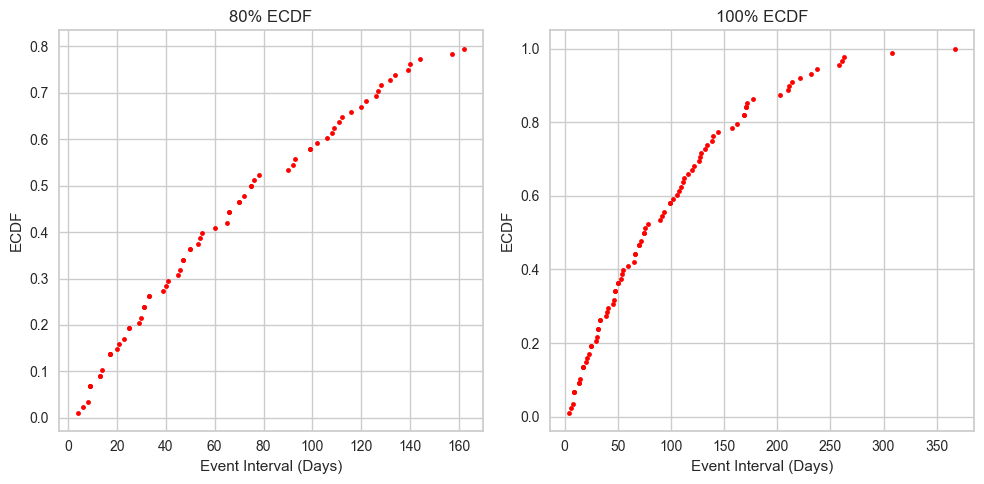

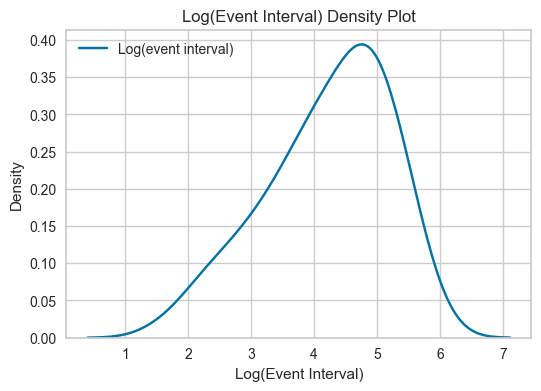

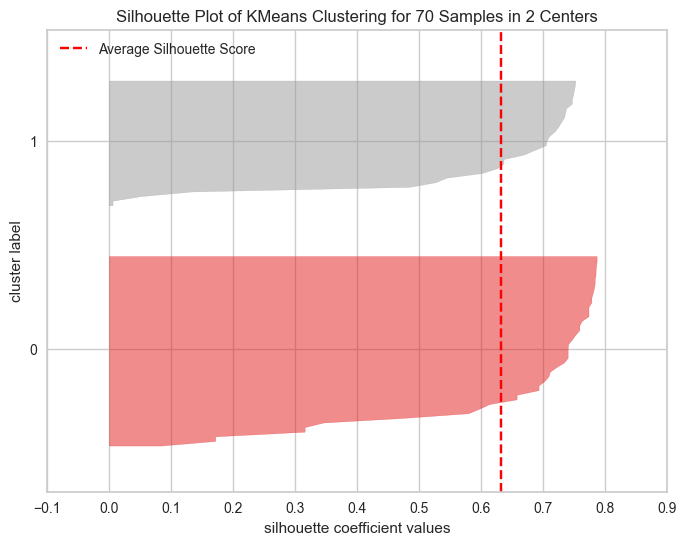

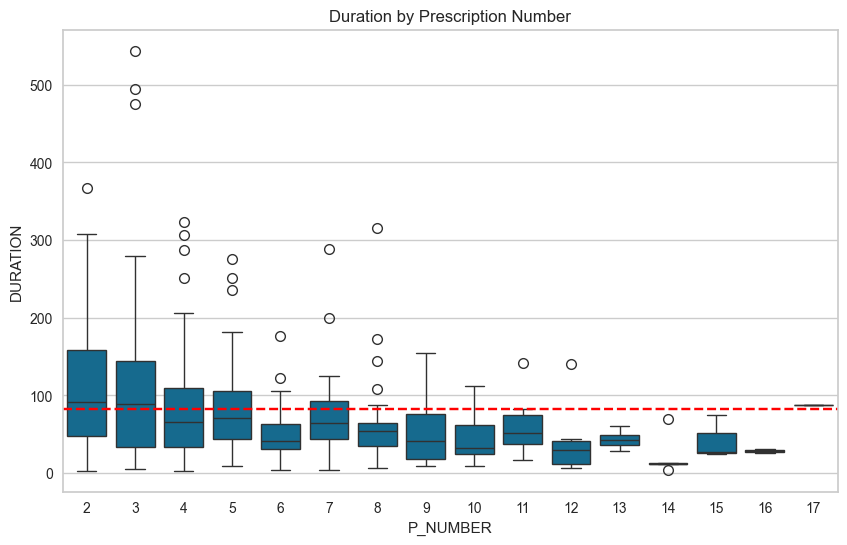

C:\Users\Cedric\AppData\Local\Temp\ipykernel_18980\2444980973.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_see_p1 = (df_see_p1.groupby("PATIENT_ID", group_keys=False).apply(lambda x: x.sample(1, random_state= 1234)).reset_index(drop=True))


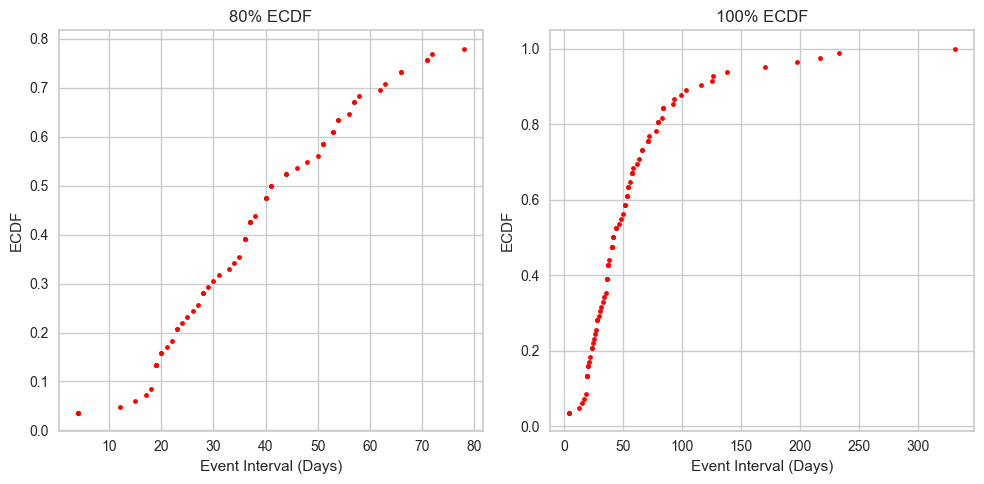

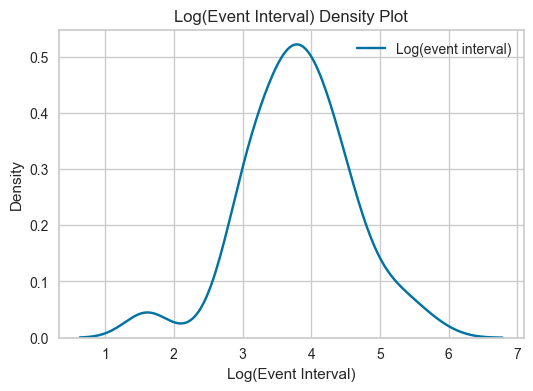

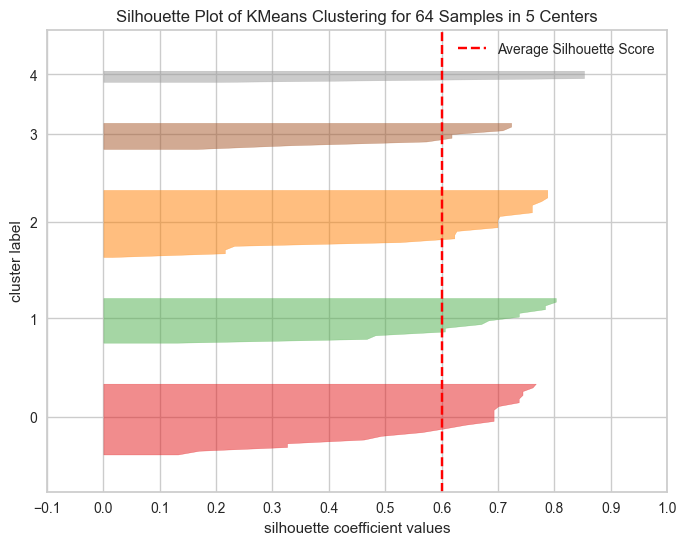

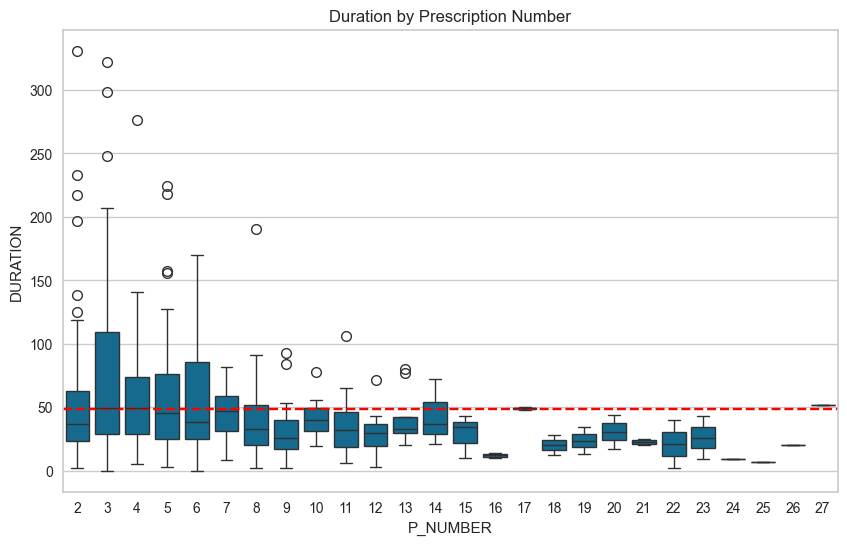

In [54]:
final_df_kMeans = main_kmeans("medA")
final_df_kMeans = main_kmeans("medB")

#### IV(B). Sessa Empirical Estimator Using DBSCAN

C:\Users\Cedric\AppData\Local\Temp\ipykernel_18980\1478171955.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_see_p1 = (df_see_p1.groupby("PATIENT_ID", group_keys=False).apply(lambda x: x.sample(1, random_state= 1234)).reset_index(drop=True))


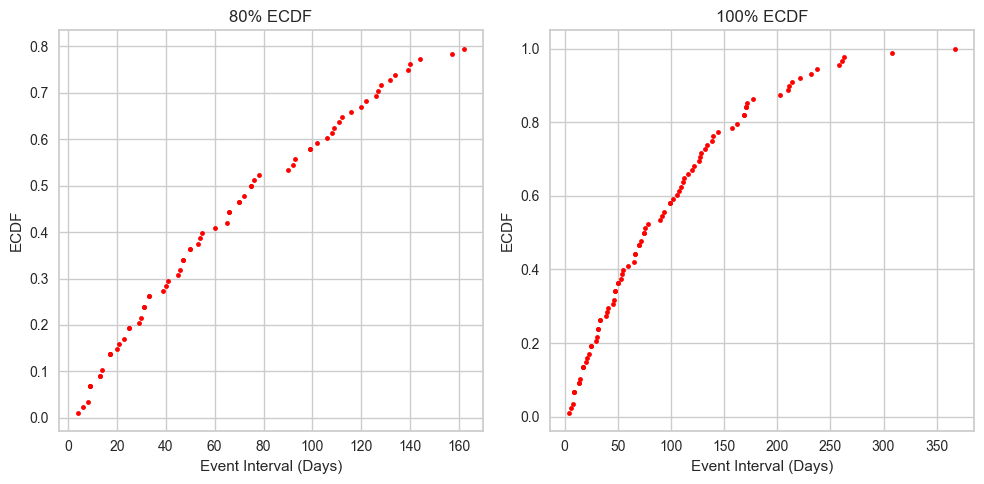

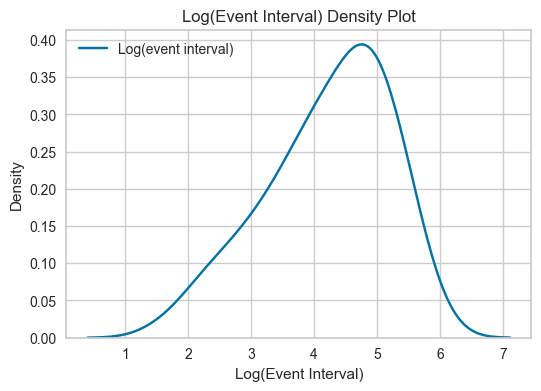

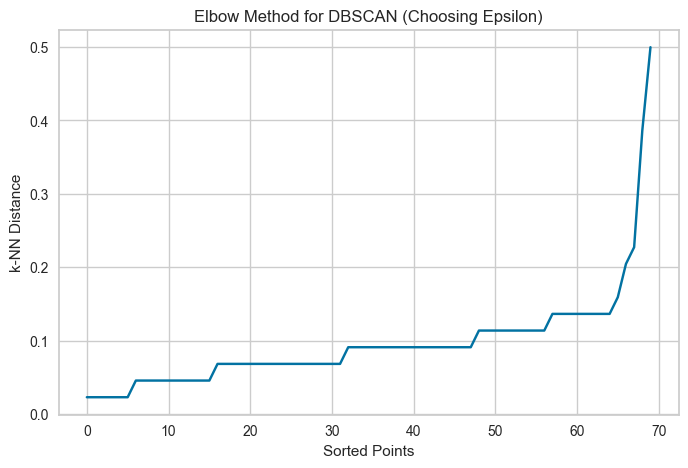

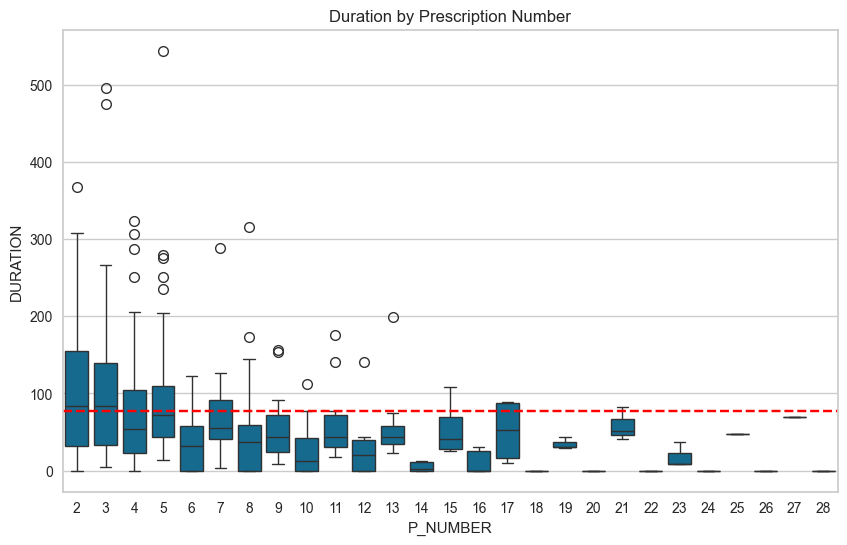

C:\Users\Cedric\AppData\Local\Temp\ipykernel_18980\1478171955.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_see_p1 = (df_see_p1.groupby("PATIENT_ID", group_keys=False).apply(lambda x: x.sample(1, random_state= 1234)).reset_index(drop=True))


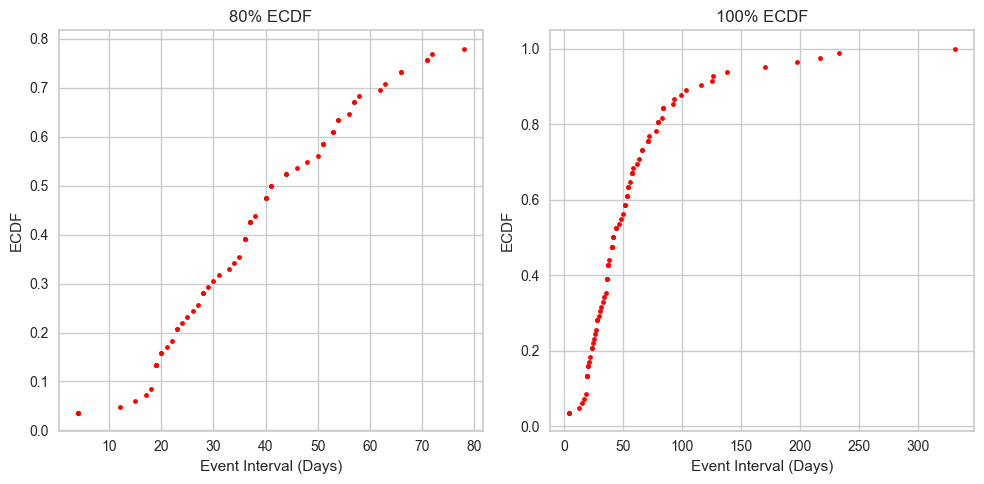

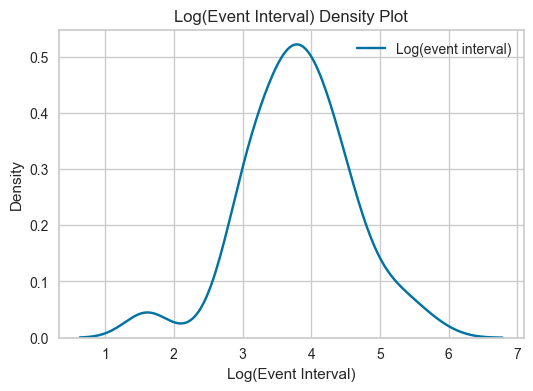

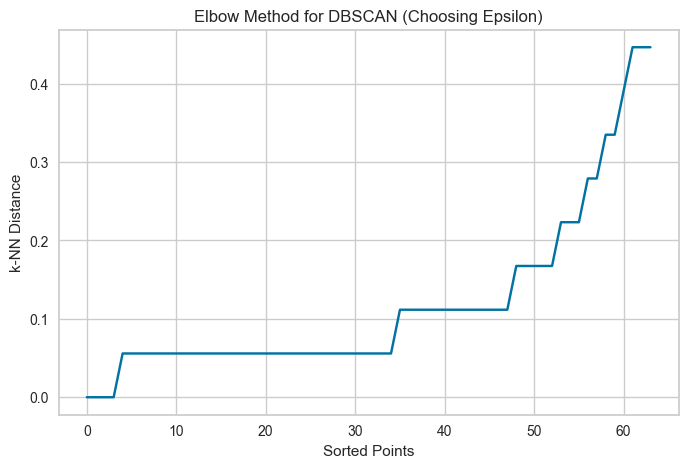

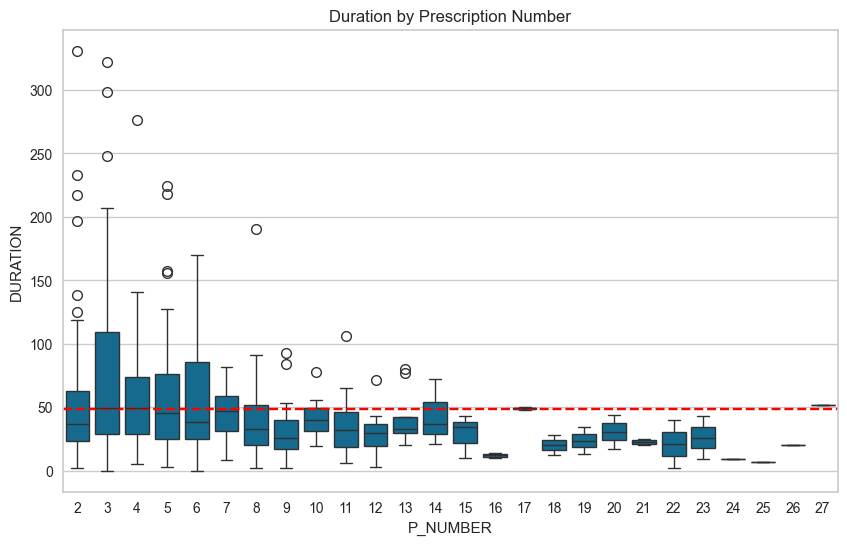

In [55]:
final_df_dbscan = main_dbscan("medA")
final_df_dbscan.to_csv("DBSCANA.csv", index=False)
final_df_dbscan = main_dbscan("medB")
final_df_dbscan.to_csv("DBSCANB.csv", index=False)

### IV. Insights 
- The first few refills of the box and whisker plot (P_NUMBER 2-6) vary greatly in range of durations with longer whiskers and even greater outliers (>300) both above and below the median (around 50 days) suggesting that users beginning a medication don't strictly adhere to medication schedules. However, this inconsistency gradually decreases and stabilizes in the subsequent refill numbers (P_NUMBER 12+) as the refills become more stabilized and consistent at around or slightly below the median duration suggesting that users have established regular refill habits.

- This evidence is further supported by the log interval density plot (KDE plot) that has a sharp peak at log(4) or 54 days in real scale with a small secondary peak at log 1-2 or 3-4 days suggesting some patients refill much sooner than the median duration. A right tail can be observed after the main peak suggesting there are few patients that have much longer refill gaps.

- The ecdf visualization shows a smooth curve that suggests a steady distribution with 80% of refill intervals being within 75 days 

#### K-Means
- The Kmeans clustering determined 5 clusters with a silhouette score of around 0.6 which is fairly close to 1 indicating averagely separated clusters. Clusters 0 and 2 have wider silhouette bars, indicating a greater range of silhouette scores within those clusters while Clusters 0, 1, and 3 have narrowers silhouettes indicating a better fit for the event intervals within that cluster * needs further explannation on each cluster overlap and matching silhouette score

#### DBSCAN
- The elbow method to determin epsilon value *tog sa ko